# Model-based aversive learning in humans is supported by preferential task state reactivation
Wise*, Liu*, Chowdhury, & Dolam (2021)

## Temporal generalisation

#### _This is a template that will be parameterised and run via [Papermill](http://papermill.readthedocs.io/) for each subject_

This notebook trains classifiers on the localiser data and uses them to predict choices on the task, giving us an index of reactivation.

Temporal generalisation steps:

1. Loading preprocessed data
2. Training classifiers to predict distinguish pairs of stimuli (e.g. start stimuli for both paths) on the localiser
3. Applying these classifiers to the task data to predict choice


## Imports

In [16]:
import sys
sys.path.insert(0, 'code')
import os
import mne
from mne.decoding import SlidingEstimator, cross_val_multiscore, UnsupervisedSpatialFilter, GeneralizingEstimator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import halfcauchy
from sklearn.metrics import make_scorer
from sliding_window_classifiers import *

%matplotlib inline

np.random.seed(100)

### Useful functions

In [17]:
def score_and_plot(clf, X, y, epochs):

    scores = cross_val_multiscore(clf, X, y, cv=5, n_jobs=1)

    # Mean scores across cross-validation splits
    mean_scores = np.mean(scores, axis=0)
    best_idx = np.where(mean_scores == mean_scores.max())[0][0]

    # Plot
    fig, ax = plt.subplots(dpi=100)
    ax.axhline(1. / 2, color='#a8a8a8', linestyle='--', label='Chance')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Subset accuracy')
    ax.axvline(.0, color='#515151', linestyle='-')
    ax.set_title('Decoding accuracy')

    corrected_times = epochs.times  

    ax.plot(corrected_times[:len(mean_scores)], mean_scores, label='Score')
    ax.axvline(corrected_times[best_idx], color='#76b9e8', linestyle='--')

    ax.legend()
    plt.tight_layout()
    
    return scores
    
def time_accuracy(y, y_pred):
    acc = y_pred == y[:, np.newaxis]
    return (acc.sum(axis=0) / acc.shape[0]).mean()

time_accuracy_scorer = make_scorer(time_accuracy)

## Parameters

In [18]:
# DEFAULT PARAMETERS - OVERRRIDEN BY PAPERMILL EXECUTION
session_id = '001'  # ID of the scanning session
n_stim = 14  # Number of stimuli
n_iter_search = 100  # Number of iterations of the random search parameter optimisation procedure
pca_n_components = 50  # Number of components used for PCA prior to classification
classifier_regularisation = 'l1'  # Type of regularisation to use in the classifier
param_optimisation_cv = 3  # Number of CV folds to use in evaluating the classifier
cores = 1  # Number of cores to use for parallel processing
os.environ['OMP_NUM_THREADS'] = str(cores)


In [19]:
preprocessing_dir = 'data/derivatives/preprocessing/sub-{0}'.format(session_id)  # Where the output data should go
output_dir = 'data/derivatives/temporal_generalisation/sub-{0}'.format(session_id)  # Where the output data should go

## Get data

This loads preprocessed data for the localiser and rest/outcome phases of the task

In [20]:
""" localiser_epochs = mne.read_epochs(os.path.join(output_dir, 'localiser', 'sub-{0}_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz').format(session_id))
planning_epochs = mne.read_epochs(os.path.join(output_dir, 'task', 'sub-{0}_ses-01_task-AversiveLearningReplay_run-planning_proc_ICA-epo.fif.gz').format(session_id))
outcome_epochs = mne.read_epochs(os.path.join(output_dir, 'task', 'sub-{0}_ses-01_task-AversiveLearningReplay_run-outcome_proc_ICA-epo.fif.gz').format(session_id)) """
localiser_epochs = mne.read_epochs(os.path.join(preprocessing_dir, 'localiser', 'sub-{0}_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz').format(session_id))
planning_epochs = mne.read_epochs(os.path.join(preprocessing_dir, 'task', 'sub-{0}_ses-01_task-AversiveLearningReplay_run-planning_proc_ICA-epo.fif.gz').format(session_id))
outcome_epochs = mne.read_epochs(os.path.join(preprocessing_dir, 'task', 'sub-{0}_ses-01_task-AversiveLearningReplay_run-outcome_proc_ICA-epo.fif.gz').format(session_id))

Reading /content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/data/derivatives/preprocessing/sub-001/localiser/sub-001_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz ...
    Read 5 compensation matrices
    Found the data of interest:
        t =    -500.00 ...     790.00 ms
        5 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
900 matching events found
No baseline correction applied
0 projection items activated
Reading /content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/data/derivatives/preprocessing/sub-001/task/sub-001_ses-01_task-AversiveLearningReplay_run-planning_proc_ICA-epo.fif.gz ...
    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    5990.00 ms
        5 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activate

## Trim epochs

Here we remove any time before the start of the epoch as we don't need it for this analysis

In [21]:
localiser_epochs.crop(0, None)
outcome_epochs.crop(None, 2.8)
planning_epochs.crop(0, None)

<ipython-input-21-eb2fa780c2c3>:2: RuntimeWarning: tmax is not in epochs time interval. tmax is set to epochs.tmax
  outcome_epochs.crop(None, 2.8)


Number of events,120
Events,planning: 120
Time range,0.000 – 5.990 sec
Baseline,0.000 – 0.000 sec


In [22]:
localiser_epochs.pick_types(meg=True, ref_meg=False)
outcome_epochs.pick_types(meg=True, ref_meg=False)
planning_epochs.pick_types(meg=True, ref_meg=False)

Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.


Number of events,120
Events,planning: 120
Time range,0.000 – 5.990 sec
Baseline,0.000 – 0.000 sec


In [23]:
outcome_dropped = np.zeros(len(outcome_epochs)).astype(bool)
localiser_dropped = np.zeros(len(localiser_epochs)).astype(bool)
planning_dropped = np.zeros(len(planning_epochs)).astype(bool)

## Set up classifiers and train on localiser

### Base classifier

First we create classifier instances that will be used for all further analyses. We use a regularised logistic regression, with the data subject to dimensionality reduction through PCA.

We will train and test this classifier on the localiser data first, optimising the regularisation parameter (`C`) to find the best decoding accuracy. We will then use this value of `C` in our temporal generalisation analysis. 

In [24]:
clf = make_pipeline(StandardScaler(), LogisticRegression(C=0.1, penalty=classifier_regularisation, class_weight="balanced", solver='liblinear'))
pca = UnsupervisedSpatialFilter(PCA(pca_n_components), average=False)
pca.fit(localiser_epochs.get_data())
sliding = SlidingEstimator(clf, scoring='accuracy', n_jobs=1, verbose=False)
param_dist = {"base_estimator__logisticregression__C": halfcauchy(scale=5)}
random_search = RandomizedSearchCV(sliding, param_distributions=param_dist,
                                   n_iter=100, cv=param_optimisation_cv, n_jobs=1, scoring=time_accuracy_scorer, verbose=1);

### Learning paths - Start states

Here we train a classifier to distinguish the two images representing the first image in each learning path.

Fitting 3 folds for each of 100 candidates, totalling 300 fits


  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

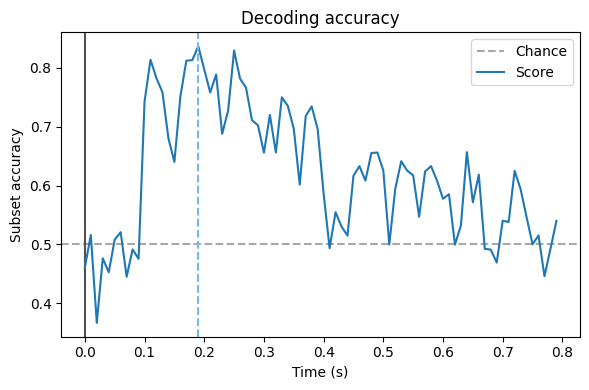

In [25]:
localiser_X_data = pca.transform(localiser_epochs[['stimulus_2', 'stimulus_8']].get_data())
random_search.fit(X=localiser_X_data,  y=localiser_epochs[['stimulus_2', 'stimulus_8']].events[:, 2] > 2)
best_C_learning = random_search.best_params_['base_estimator__logisticregression__C']
scores = score_and_plot(random_search.best_estimator_, localiser_X_data, localiser_epochs[['stimulus_2', 'stimulus_8']].events[:, 2] > 2, localiser_epochs)

### Generalisation paths - Start states

This trains a classifier to distinguish between the images representing the start states in the two generalisation paths.

Fitting 3 folds for each of 100 candidates, totalling 300 fits


  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

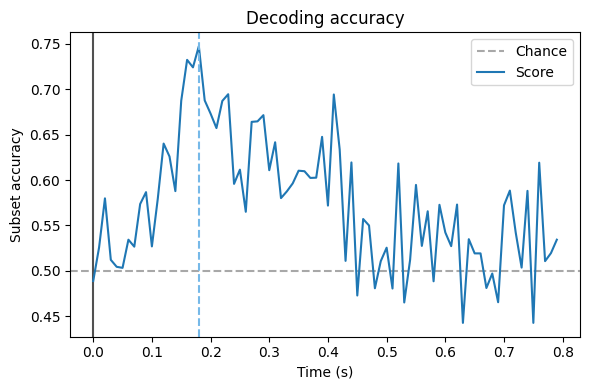

In [26]:
localiser_X_data = pca.transform(localiser_epochs[['stimulus_4', 'stimulus_6']].get_data())
random_search.fit(X=localiser_X_data,  y=localiser_epochs[['stimulus_4', 'stimulus_6']].events[:, 2] > 4)
best_C_generalisation = random_search.best_params_['base_estimator__logisticregression__C']
scores = score_and_plot(random_search.best_estimator_, localiser_X_data, localiser_epochs[['stimulus_4', 'stimulus_6']].events[:, 2] > 4, localiser_epochs)

### End states

This trains a classifier to distinguish between the images representing the two end states.

Fitting 3 folds for each of 100 candidates, totalling 300 fits


  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]

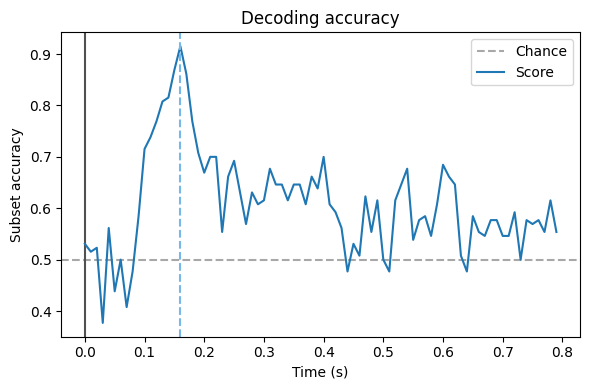

In [27]:
localiser_X_data = pca.transform(localiser_epochs[['stimulus_26', 'stimulus_28']].get_data())
random_search.fit(X=localiser_X_data,  y=localiser_epochs[['stimulus_26', 'stimulus_28']].events[:, 2] > 26)
best_C_end = random_search.best_params_['base_estimator__logisticregression__C']
scores = score_and_plot(random_search.best_estimator_, localiser_X_data, localiser_epochs[['stimulus_26', 'stimulus_28']].events[:, 2] > 26, localiser_epochs)

### Set up generalising estimator for learning and generalisation start states, and end states

Here we set up classifiers that are used for the temporal generalisation analysis, using the optimal values for `C` determined in the prior analyses. 

In [28]:
clf_learning = make_pipeline(StandardScaler(), LogisticRegression(C=best_C_learning, penalty=classifier_regularisation, class_weight="balanced", solver='liblinear'))
clf_generalisation = make_pipeline(StandardScaler(), LogisticRegression(C=best_C_generalisation, penalty=classifier_regularisation, class_weight="balanced", solver='liblinear'))
clf_end = make_pipeline(StandardScaler(), LogisticRegression(C=best_C_end, penalty=classifier_regularisation, class_weight="balanced", solver='liblinear'))

time_gen_learning = GeneralizingEstimator(clf_learning, scoring='accuracy', n_jobs=1, verbose=False)
time_gen_generalisation = GeneralizingEstimator(clf_generalisation, scoring='accuracy', n_jobs=1, verbose=False)
time_gen_end = GeneralizingEstimator(clf_end, scoring='accuracy', n_jobs=1, verbose=False)


And we then fit these to the localiser data. This involves training a classifier on each timepoint of the localiser trials, which we can then apply to each timepoint in the task trials.

In [29]:
time_gen_learning.fit(X=pca.transform(localiser_epochs[['stimulus_2', 'stimulus_8']].get_data()), y=localiser_epochs[['stimulus_2', 'stimulus_8']].events[:, 2] > 2)
time_gen_generalisation.fit(X=pca.transform(localiser_epochs[['stimulus_4', 'stimulus_6']].get_data()), y=localiser_epochs[['stimulus_4', 'stimulus_6']].events[:, 2] > 4)
time_gen_end.fit(X=pca.transform(localiser_epochs[['stimulus_26', 'stimulus_28']].get_data()), y=localiser_epochs[['stimulus_26', 'stimulus_28']].events[:, 2] > 26)

  0%|          | Fitting GeneralizingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/80 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/80 [00:00<?,       ?it/s]

<GeneralizingEstimator(base_estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.565759223628037,
                                    class_weight='balanced', penalty='l1',
                                    solver='liblinear'))]),
           n_jobs=1, scoring='accuracy', fitted with 80 estimators, fitted with 80 estimators>

## Predict behaviour on the task

Next we use our classifiers to predict which paths subjects chose on each trial. We assume that if we can classify behaviour using a classifer trained only on the perceptual qualities used to define each state, this provides evidence that those perceptual qualities are being reactivated in a way that is associated with behaviour.

### Get behaviour

In [33]:
data_dir = os.path.join('data') #was not defined

beh_data_dir = os.path.join(data_dir, 'sub-{0}'.format(session_id), 'ses-01', 'beh')

behaviour = pd.read_csv(os.path.join(beh_data_dir, 'sub-{0}_ses-01_task-AversiveLearningReplay_responses.csv'.format(session_id)))

In [34]:
behaviour.head()

,Unnamed: 0,Unnamed: 0.1,Subject,trial_number,State_1_chosen,State_2_chosen,State_3_chosen,outcome_type,State_1_shown,State_2_shown,State_3_shown,State_4_shown,RT_1,RT_2,RT_3,Shock_received,trial_type,State_12_shock,State_13_shock
0,0,0,sub-001,0,3,7,11,invalid_choices,3,7,11,13,NaN,NaN,NaN,True,0,True,True
1,1,1,sub-001,1,3,7,11,choices_entered,3,7,11,13,NaN,NaN,NaN,False,0,False,False
2,2,2,sub-001,2,0,4,8,choices_entered,0,4,8,12,NaN,NaN,NaN,False,0,False,False
3,3,3,sub-001,3,0,4,8,choices_entered,0,4,8,12,NaN,NaN,NaN,False,0,False,True
4,4,4,sub-001,4,1,5,9,choices_entered,1,5,9,12,NaN,NaN,NaN,NaN,1,False,True


### Apply PCA to task data

In [35]:
outcome_X_data = pca.transform(outcome_epochs.get_data())
planning_X_data = pca.transform(planning_epochs.get_data())

### Apply classifers to task data and score

This loops through each time point in the planning and rest periods of the task, applying the localiser trained on every time point at each. We look at learning and generalisation trials both together and separately to determine effects that are present across all and those that are specific to one trial type.

In [36]:
# Outcome - all trials
all_trials_outcome_learning_scores = time_gen_learning.score(X=outcome_X_data, y=behaviour[behaviour.trial_type == 0].loc[~outcome_dropped.astype(bool), 'State_4_shown'] > 12)
all_trials_outcome_generalisation_scores = time_gen_generalisation.score(X=outcome_X_data, y=behaviour[behaviour.trial_type == 0].loc[~outcome_dropped.astype(bool), 'State_4_shown'] > 12)
all_trials_outcome_end_scores = time_gen_end.score(X=outcome_X_data, y=behaviour[behaviour.trial_type == 0].loc[~outcome_dropped.astype(bool), 'State_4_shown'] > 12)

# Planning - all trials
all_trials_planning_learning_scores = time_gen_learning.score(X=planning_X_data, y=behaviour.loc[~planning_dropped.astype(bool), 'State_4_shown'] > 12)
all_trials_planning_generalisation_scores = time_gen_generalisation.score(X=planning_X_data, y=behaviour.loc[~planning_dropped.astype(bool), 'State_4_shown'] > 12)
all_trials_planning_end_scores = time_gen_end.score(X=planning_X_data, y=behaviour.loc[~planning_dropped.astype(bool), 'State_4_shown'] > 12)

# Planning - learning trials
planning_behaviour = behaviour[~planning_dropped]
learning_trials_planning_learning_scores = time_gen_learning.score(X=planning_X_data[planning_behaviour.trial_type == 0], 
                                                                   y=planning_behaviour[planning_behaviour.trial_type == 0]['State_4_shown'] > 12)
learning_trials_planning_generalisation_scores = time_gen_generalisation.score(X=planning_X_data[planning_behaviour.trial_type == 0], 
                                                                               y=planning_behaviour[planning_behaviour.trial_type == 0]['State_4_shown'] > 12)
learning_trials_planning_end_scores = time_gen_end.score(X=planning_X_data[planning_behaviour.trial_type == 0], 
                                                         y=planning_behaviour[planning_behaviour.trial_type == 0]['State_4_shown'] > 12)

# Planning - generalisation trials
generalisation_trials_planning_learning_scores = time_gen_learning.score(X=planning_X_data[planning_behaviour.trial_type == 1], 
                                                                         y=planning_behaviour[planning_behaviour.trial_type == 1]['State_4_shown'] > 12)
generalisation_trials_planning_generalisation_scores = time_gen_generalisation.score(X=planning_X_data[planning_behaviour.trial_type == 1], 
                                                                                     y=planning_behaviour[planning_behaviour.trial_type == 1]['State_4_shown'] > 12)
generalisation_trials_planning_end_scores = time_gen_end.score(X=planning_X_data[planning_behaviour.trial_type == 1], 
                                                               y=planning_behaviour[planning_behaviour.trial_type == 1]['State_4_shown'] > 12)

  0%|          | Scoring GeneralizingEstimator : 0/32000 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/32000 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/32000 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/48000 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/48000 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/48000 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/48000 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/48000 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/48000 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/48000 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/48000 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/48000 [00:00<?,       ?it/s]

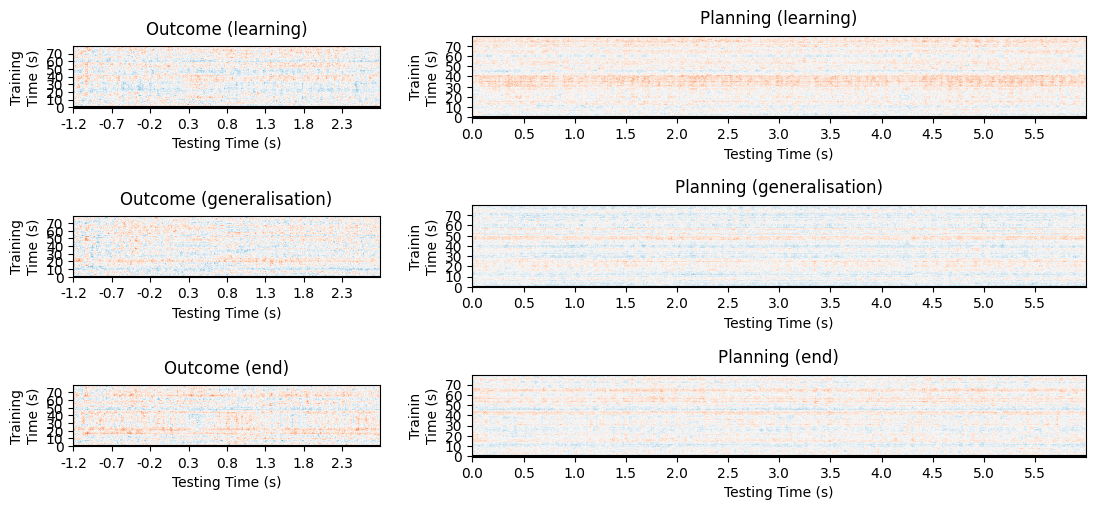

In [37]:
fig, ax = plt.subplots(3, 2, figsize=(15, 8), dpi=100, gridspec_kw={'width_ratios': [0.5, 1]})

labels = ['learning', 'generalisation', 'end']

for n, i in enumerate([all_trials_outcome_learning_scores, all_trials_outcome_generalisation_scores, all_trials_outcome_end_scores]):
    
    im = ax[n, 0].matshow(i, vmin=0, vmax=1., cmap='RdBu_r', origin='lower')
    ax[n, 0].axhline(0., color='k')
    ax[n, 0].axvline(0., color='k')
    ax[n, 0].xaxis.set_ticks_position('bottom')
    ax[n, 0].set_xticks(np.arange(0, len(outcome_epochs.times), 50))
    ax[n, 0].set_xticklabels(outcome_epochs.times[::50])
    ax[n, 0].set_xlabel('Testing Time (s)')
    ax[n, 0].set_ylabel('Training\nTime (s)')
    ax[n, 0].set_title('Outcome ({0})'.format(labels[n]))

for n, i in enumerate([all_trials_planning_learning_scores, all_trials_planning_generalisation_scores, all_trials_planning_end_scores]):
    
    im = ax[n, 1].matshow(i, vmin=0, vmax=1., cmap='RdBu_r', origin='lower')
    ax[n, 1].axhline(0., color='k')
    ax[n, 1].axvline(0., color='k')
    ax[n, 1].xaxis.set_ticks_position('bottom')
    ax[n, 1].set_xticks(np.arange(0, len(planning_epochs.times), 50))
    ax[n, 1].set_xticklabels(planning_epochs.times[::50])
    ax[n, 1].set_xlabel('Testing Time (s)')
    ax[n, 1].set_ylabel('Trainin\nTime (s)')
    ax[n, 1].set_title('Planning ({0})'.format(labels[n]))
plt.subplots_adjust(bottom=0.3, right=0.8, top=0.9)

## Save

In [38]:
if not os.path.exists(os.path.join(output_dir, 'temporal_generalisation/outcome/all_trials')):
    os.makedirs(os.path.join(output_dir, 'temporal_generalisation/outcome/all_trials'))
if not os.path.exists(os.path.join(output_dir, 'temporal_generalisation/planning/all_trials')):
    os.makedirs(os.path.join(output_dir, 'temporal_generalisation/planning/all_trials'))
if not os.path.exists(os.path.join(output_dir, 'temporal_generalisation/planning/learning_trials')):
    os.makedirs(os.path.join(output_dir, 'temporal_generalisation/planning/learning_trials'))
if not os.path.exists(os.path.join(output_dir, 'temporal_generalisation/planning/generalisation_trials')):
    os.makedirs(os.path.join(output_dir, 'temporal_generalisation/planning/generalisation_trials'))

In [39]:
np.save(os.path.join(output_dir, 'temporal_generalisation/outcome/all_trials', 'sub-{0}_learning_stimulus_outcome').format(session_id), all_trials_outcome_learning_scores)
np.save(os.path.join(output_dir, 'temporal_generalisation/outcome/all_trials', 'sub-{0}_generalisation_stimulus_outcome').format(session_id), all_trials_outcome_generalisation_scores)
np.save(os.path.join(output_dir, 'temporal_generalisation/outcome/all_trials', 'sub-{0}_end_stimulus_outcome').format(session_id), all_trials_outcome_end_scores)

np.save(os.path.join(output_dir, 'temporal_generalisation/planning/all_trials', 'sub-{0}_learning_stimulus_planning').format(session_id), all_trials_planning_learning_scores)
np.save(os.path.join(output_dir, 'temporal_generalisation/planning/all_trials', 'sub-{0}_generalisation_stimulus_planning').format(session_id), all_trials_planning_generalisation_scores)
np.save(os.path.join(output_dir, 'temporal_generalisation/planning/all_trials', 'sub-{0}_end_stimulus_planning').format(session_id), all_trials_planning_end_scores)

np.save(os.path.join(output_dir, 'temporal_generalisation/planning/learning_trials', 'sub-{0}_learning_stimulus_planning').format(session_id), learning_trials_planning_learning_scores)
np.save(os.path.join(output_dir, 'temporal_generalisation/planning/learning_trials', 'sub-{0}_generalisation_stimulus_planning').format(session_id), learning_trials_planning_generalisation_scores)
np.save(os.path.join(output_dir, 'temporal_generalisation/planning/learning_trials', 'sub-{0}_end_stimulus_planning').format(session_id), learning_trials_planning_end_scores)

np.save(os.path.join(output_dir, 'temporal_generalisation/planning/generalisation_trials', 'sub-{0}_learning_stimulus_planning').format(session_id), generalisation_trials_planning_learning_scores)
np.save(os.path.join(output_dir, 'temporal_generalisation/planning/generalisation_trials', 'sub-{0}_generalisation_stimulus_planning').format(session_id), generalisation_trials_planning_generalisation_scores)
np.save(os.path.join(output_dir, 'temporal_generalisation/planning/generalisation_trials', 'sub-{0}_end_stimulus_planning').format(session_id), generalisation_trials_planning_end_scores)

### Apply classifers to task data to get probabilistic predictions

This loops through each time point in the planning and rest periods of the task, applying the localiser trained on every time point at each. We look at learning and generalisation trials both together and separately to determine effects that are present across all and those that are specific to one trial type.

In [ ]:
# Outcome - all trials
all_trials_outcome_learning_pred = time_gen_learning.predict_proba(X=outcome_X_data)
all_trials_outcome_generalisation_pred = time_gen_generalisation.predict_proba(X=outcome_X_data)
all_trials_outcome_end_pred = time_gen_end.predict_proba(X=outcome_X_data)

# # Planning - all trials
all_trials_planning_learning_pred = time_gen_learning.predict_proba(X=planning_X_data)
all_trials_planning_generalisation_pred = time_gen_generalisation.predict_proba(X=planning_X_data)
all_trials_planning_end_pred = time_gen_end.predict_proba(X=planning_X_data)

# # # Planning - learning trials
planning_behaviour = behaviour[~planning_dropped]
learning_trials_planning_learning_pred = time_gen_learning.predict_proba(X=planning_X_data[planning_behaviour.trial_type == 0])
learning_trials_planning_generalisation_pred = time_gen_generalisation.predict_proba(X=planning_X_data[planning_behaviour.trial_type == 0])
learning_trials_planning_end_pred = time_gen_end.predict_proba(X=planning_X_data[planning_behaviour.trial_type == 0])

# # # Planning - generalisation trials
generalisation_trials_planning_learning_pred = time_gen_learning.predict_proba(X=planning_X_data[planning_behaviour.trial_type == 1])
generalisation_trials_planning_generalisation_pred = time_gen_generalisation.predict_proba(X=planning_X_data[planning_behaviour.trial_type == 1])
generalisation_trials_planning_end_pred = time_gen_end.predict_proba(X=planning_X_data[planning_behaviour.trial_type == 1])

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(15, 8), dpi=100, gridspec_kw={'width_ratios': [0.5, 1]})

labels = ['learning', 'generalisation', 'end']

for n, i in enumerate([all_trials_outcome_learning_pred, all_trials_outcome_generalisation_pred, all_trials_outcome_end_pred]):
    
    im = ax[n, 0].matshow(i.mean(axis=0)[:, :, 0], vmin=0, vmax=1., cmap='RdBu_r', origin='lower')
    ax[n, 0].axhline(0., color='k')
    ax[n, 0].axvline(0., color='k')
    ax[n, 0].xaxis.set_ticks_position('bottom')
    ax[n, 0].set_xticks(np.arange(0, len(outcome_epochs.times), 50))
    ax[n, 0].set_xticklabels(outcome_epochs.times[::50])
    ax[n, 0].set_xlabel('Testing Time (s)')
    ax[n, 0].set_ylabel('Training\nTime (s)')
    ax[n, 0].set_title('Outcome ({0})'.format(labels[n]))

for n, i in enumerate([all_trials_planning_learning_pred, all_trials_planning_generalisation_pred, all_trials_planning_end_pred]):
    
    im = ax[n, 1].matshow(i.mean(axis=0)[:, :, 0], vmin=0, vmax=1., cmap='RdBu_r', origin='lower')
    ax[n, 1].axhline(0., color='k')
    ax[n, 1].axvline(0., color='k')
    ax[n, 1].xaxis.set_ticks_position('bottom')
    ax[n, 1].set_xticks(np.arange(0, len(planning_epochs.times), 50))
    ax[n, 1].set_xticklabels(planning_epochs.times[::50])
    ax[n, 1].set_xlabel('Testing Time (s)')
    ax[n, 1].set_ylabel('Trainin\nTime (s)')
    ax[n, 1].set_title('Planning ({0})'.format(labels[n]))
plt.subplots_adjust(bottom=0.3, right=0.8, top=0.9)

## Save

In [ ]:
if not os.path.exists(os.path.join(output_dir, 'temporal_generalisation_predicted/outcome/all_trials')):
    os.makedirs(os.path.join(output_dir, 'temporal_generalisation_predicted/outcome/all_trials'))
if not os.path.exists(os.path.join(output_dir, 'temporal_generalisation_predicted/planning/all_trials')):
    os.makedirs(os.path.join(output_dir, 'temporal_generalisation_predicted/planning/all_trials'))
if not os.path.exists(os.path.join(output_dir, 'temporal_generalisation_predicted/planning/learning_trials')):
    os.makedirs(os.path.join(output_dir, 'temporal_generalisation_predicted/planning/learning_trials'))
if not os.path.exists(os.path.join(output_dir, 'temporal_generalisation_predicted/planning/generalisation_trials')):
    os.makedirs(os.path.join(output_dir, 'temporal_generalisation_predicted/planning/generalisation_trials'))

In [ ]:
np.save(os.path.join(output_dir, 'temporal_generalisation_predicted/outcome/all_trials', 'sub-{0}_learning_stimulus_outcome').format(session_id), all_trials_outcome_learning_pred)
np.save(os.path.join(output_dir, 'temporal_generalisation_predicted/outcome/all_trials', 'sub-{0}_generalisation_stimulus_outcome').format(session_id), all_trials_outcome_generalisation_pred)
np.save(os.path.join(output_dir, 'temporal_generalisation_predicted/outcome/all_trials', 'sub-{0}_end_stimulus_outcome').format(session_id), all_trials_outcome_end_pred)

np.save(os.path.join(output_dir, 'temporal_generalisation_predicted/planning/all_trials', 'sub-{0}_learning_stimulus_planning').format(session_id), all_trials_planning_learning_pred)
np.save(os.path.join(output_dir, 'temporal_generalisation_predicted/planning/all_trials', 'sub-{0}_generalisation_stimulus_planning').format(session_id), all_trials_planning_generalisation_pred)
np.save(os.path.join(output_dir, 'temporal_generalisation_predicted/planning/all_trials', 'sub-{0}_end_stimulus_planning').format(session_id), all_trials_planning_end_pred)

np.save(os.path.join(output_dir, 'temporal_generalisation_predicted/planning/learning_trials', 'sub-{0}_learning_stimulus_planning').format(session_id), learning_trials_planning_learning_pred)
np.save(os.path.join(output_dir, 'temporal_generalisation_predicted/planning/learning_trials', 'sub-{0}_generalisation_stimulus_planning').format(session_id), learning_trials_planning_generalisation_pred)
np.save(os.path.join(output_dir, 'temporal_generalisation_predicted/planning/learning_trials', 'sub-{0}_end_stimulus_planning').format(session_id), learning_trials_planning_end_pred)

np.save(os.path.join(output_dir, 'temporal_generalisation_predicted/planning/generalisation_trials', 'sub-{0}_learning_stimulus_planning').format(session_id), generalisation_trials_planning_learning_pred)
np.save(os.path.join(output_dir, 'temporal_generalisation_predicted/planning/generalisation_trials', 'sub-{0}_generalisation_stimulus_planning').format(session_id), generalisation_trials_planning_generalisation_pred)
np.save(os.path.join(output_dir, 'temporal_generalisation_predicted/planning/generalisation_trials', 'sub-{0}_end_stimulus_planning').format(session_id), generalisation_trials_planning_end_pred)